### **2D Galaxy Power Spectrum Calculation with Example Model Fits:**

**Last Run: 8/5/2019**

For any questions, suggestions, or issues with the notebook please email Sam Goldstein at samgolds@sas.upenn.edu

This notebook features an example calculation of the 2D galaxy power spectrum using the *baseDC2_snapshot_z101_v0.1*, as well as one and two parameter model fitting. The main aspects of this notebook include:
* Loading DC2 snapshot catalogs and initializing appropriate cosmology objects
* Applying a Gaussian kernel to model a tomographic redshift bin used in radial galaxy selection
* Compute the 2D galaxy auto power spectrum
* Compute the 2D theoretical linear and non-linear matter power spectrum using CCL
* Fitting models relating the matter power spectrum and galaxy auto power spectrum

#### **Import Files and Setup Configuration:**

This cell imports the necessary libraries for the notebook, loads a catalog, and initializes cosmology parameters from the loaded catalog which will be used extensively throughout the notebook. Computes $\sigma_\chi$ defined as $\sigma_\chi = \frac{c}{H(z)}\sigma_z,$ and $\sigma_z \approx 0.05(1+z_{redshift})$.

In [1]:
import GCRCatalogs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pyccl
import sys

from scipy.constants import speed_of_light

sns.set(style='ticks')

%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'

# Load appropriate catalog
cat = GCRCatalogs.load_catalog("baseDC2_snapshot_z1.01_v0.1")

# Define global constants to be used in various computations
pi = np.pi
COSMO = cat.cosmology
Z_RED_SHIFT = cat.redshift
COSMO_CCL = pyccl.Cosmology(h=COSMO.h, sigma8=COSMO.sigma8,
                            Omega_g=COSMO.Ogamma0, Omega_k=COSMO.Ok0,
                            Omega_c=COSMO.Odm0, Omega_b=COSMO.Ob0,
                            n_s=COSMO.n_s, Neff=COSMO.Neff)

# Compute sigma chi
SIGMA_Z = 0.05*(1+Z_RED_SHIFT)
H_Z = COSMO.H(Z_RED_SHIFT).value

SIGMA_CHI = (speed_of_light/10**3)/H_Z*SIGMA_Z

#### **Load Position Data, Apply Preliminary Cuts, and Filter with Gaussian Kernel:**

Load the data appropriately depending on user-defined cuts. Additionally, removes all galaxies with $r_{mag} > 24.5$. Applies a Gaussian kernel to the z position data centered at $\bar{z}$ with standard deviation $\sigma_\chi$, hence selecting galaxies acccording to $e^{-\frac{(z-\bar{z})^2}{2\sigma_\chi^2}}$. For this notebook we save all of the galaxy positions so that we can provide graphs of the pre and post-masked position data for clarification, for a more memory efficient galaxy loading and masking procedure see dark_matter_and_galaxy_power_spectrum_modeling.ipynb

In [2]:
def load_galaxy_positions(cat, x_bounds, y_bounds, z_bounds, mag_cut):
    """
    Loads and applies preliminary filters to galaxy position data in Mpc
    from a specified catalog

    Parameters:
    cat (GCRCatalog): catalog to load data from
    x_bounds (float tuple): 2 element tuple with (x_min, x_max)
    y_bounds (float tuple): 2 element tuple with (y_min, y_max)
    z_bounds (float tuple): 2 element tuple with (z_min, z_max)
    mag_cut (float): apparent magnitude cut value (max value)

    Returns:
    x_data (float array): np array containing x positions of galaxies in Mpc
    y_data (float array): np array containing y positions of galaxies in Mpc
    z_ data (float array): np array containing z positions of galaxies in Mpc
    """

    # Setup box bounds in Mpc
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds
    min_z, max_z = z_bounds
    
    print("Loading Catalog Data: ")

    cat_vals = cat.get_quantities(["position_x", "position_y", "position_z",
                                   "Mag_true_r_lsst_z0"],
                                  filters=["position_z > {}".format(min_z),
                                           "position_z < {}".format(max_z),
                                           "position_x < {}".format(max_x),
                                           "position_x > {}".format(min_x),
                                           "position_y < {}".format(max_y),
                                           "position_y > {}".format(min_y)])
    
    print("Applying Apparent Magnitude Cut: ")

    # Convert absolute to apparent magnitude
    r_Mag = cat_vals["Mag_true_r_lsst_z0"]
    r_mag = r_Mag+cat.cosmology.distmod(Z_RED_SHIFT).value

    # Remove all entries below mag_cut
    filtered_indices = np.where(r_mag < mag_cut)[0]

    x_data = cat_vals["position_x"][filtered_indices]
    y_data = cat_vals["position_y"][filtered_indices]
    z_data = cat_vals["position_z"][filtered_indices]

    return x_data, y_data, z_data


def mask_galaxy_positions(x_data, y_data, z_data):
    """
    Applies a gaussian mask to select galaxies based on their z position

    Parameters:
    x_data (float array): np array containing x positions of galaxies in Mpc
    y_data (float array): np array containing y positions of galaxies in Mpc
    z_ data (float array): np array containing z positions of galaxies in Mpc

    Returns:
    x_data (float array): np array containing x positions of masked galaxies
    in Mpc
    y_data (float array): np array containing y positions of masked galaxies 
    in Mpc
    z_ data (float array): np array containing z positions of masked galaxies 
    in Mpc
    """

    # Apply Gaussian kernel
    z_bar = np.mean(z_data)
    cutoffs = np.random.uniform(0, 1, len(z_data))

    mask_ind = np.where(cutoffs <
                        np.exp(-(z_data-z_bar)**2/(2*SIGMA_CHI**2)))[0]

    x_masked = x_data[mask_ind]
    y_masked = y_data[mask_ind]
    z_masked = z_data[mask_ind]

    return x_masked, y_masked, z_masked

# Load position data
x_bounds = (0, 4232)
y_bounds = (0, 4232)
z_bounds = (1116, 3116)
mag_cut = 24.5

x_data, y_data, z_data = load_galaxy_positions(cat, x_bounds, y_bounds,
                                               z_bounds, mag_cut)

# Apply Gaussian mask
x_masked, y_masked, z_masked = mask_galaxy_positions(x_data, y_data, z_data)

# Compute N_BAR (average number of galaxies per Mpc^2)
x_width = np.max(x_masked)-np.min(x_masked)
y_width = np.max(y_masked)-np.min(y_masked)

N_BAR = len(x_masked)/(x_width*y_width)

Loading Catalog Data: 
Applying Apparent Magnitude Cut: 


#### **Plot Loaded and Masked Position Data:**

In this cell we plot position data before and after applying the Gaussian kernel and overlay the radial distribution with an appropriatly normalized overlayed Gaussian, $e^{-\frac{(z-\bar{z})^2}{2\sigma_\chi^2}}$. 

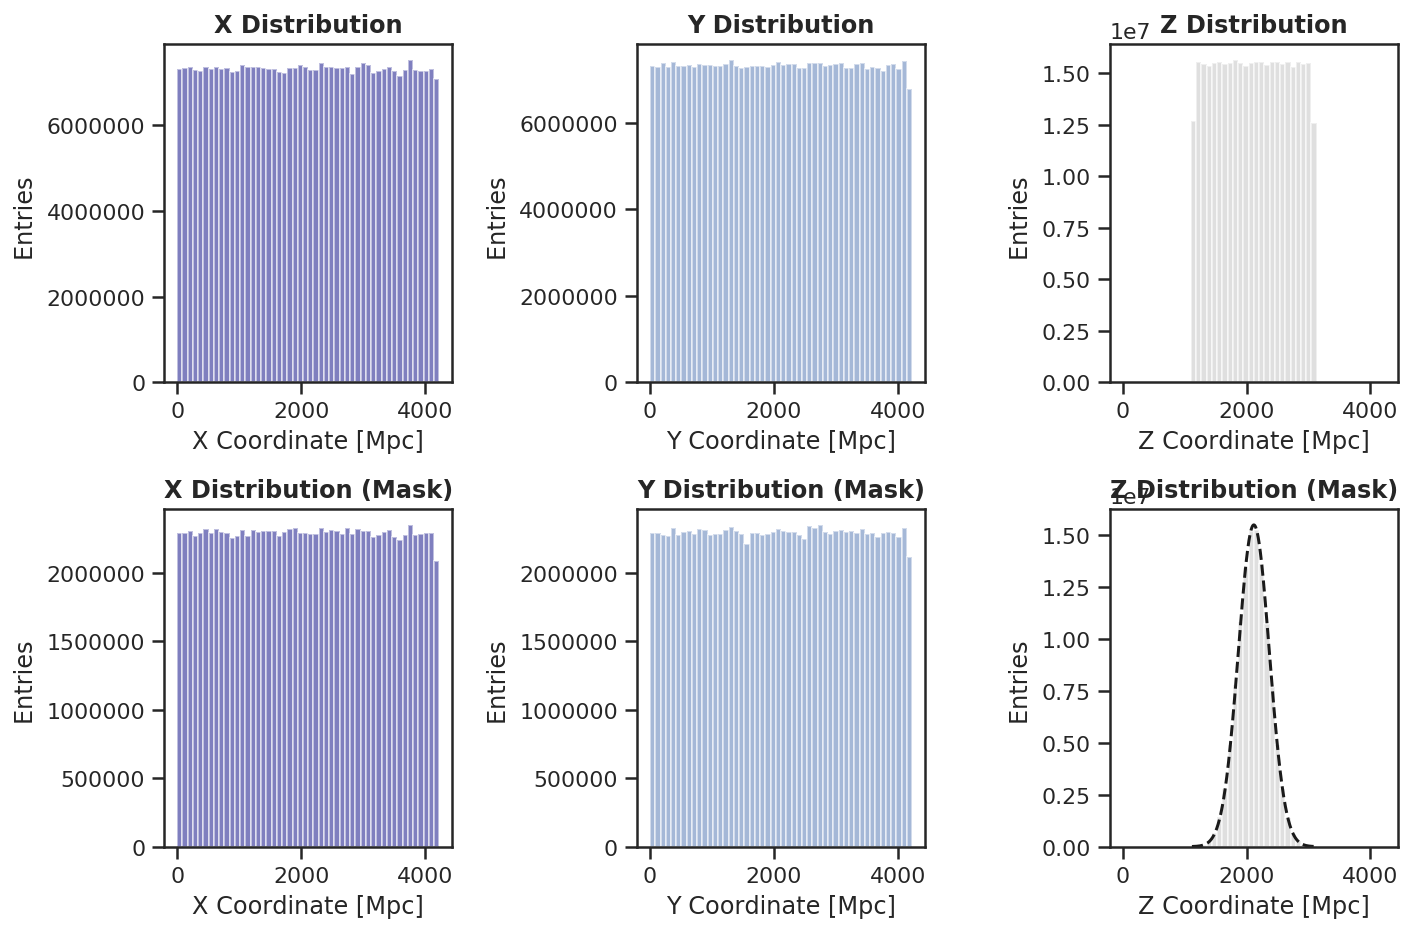

In [3]:
# Plot masked and unmasked histograms
fig = plt.figure(figsize=(10, 6.6))
n_bins = 50

bin_width = 4232/n_bins
bin_def=np.arange(0, 4232 + bin_width, bin_width)

plt.subplot(2, 3, 1)
plt.hist(x_data, bins=n_bins, alpha=0.5, color="navy")
plt.title("X Distribution", fontweight="bold")
plt.xlabel("X Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2, 3, 2)
plt.hist(y_data, bins=bin_def, alpha=0.5)
plt.title("Y Distribution", fontweight="bold")
plt.xlabel("Y Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2, 3, 3)
plt.hist(z_data, bins=bin_def, alpha=0.5, color="silver")
plt.title("Z Distribution", fontweight="bold")
plt.xlabel("Z Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2, 3, 4)
plt.hist(x_masked, bins=bin_def, alpha=0.5, color="navy")
plt.title("X Distribution (Mask)", fontweight="bold")
plt.xlabel("X Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2, 3, 5)
plt.hist(y_masked, bins=bin_def, alpha=0.5)
plt.title("Y Distribution (Mask)", fontweight="bold")
plt.xlabel("Y Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2, 3, 6)
plt.hist(z_masked, bins=bin_def, alpha=0.5, color="silver")
plt.title("Z Distribution (Mask)", fontweight="bold")
plt.xlabel("Z Coordinate [Mpc]")
plt.ylabel("Entries ")

sigma_chi_str = r"$\sigma_\chi$ = {}".format(np.round(SIGMA_CHI, 1))

# Calculate and overlay Gaussian for radial positions
min_z, max_z = z_bounds

z_vals = np.linspace(min_z, max_z, 750)
z_bar = np.mean(z_data)

exp_z = 1/(np.sqrt(2*pi)*SIGMA_CHI)*np.exp(-(z_vals-z_bar)**2/(2*SIGMA_CHI**2))

std_offset = (max_z-min_z)/(2*SIGMA_CHI)
rel_area = scipy.stats.norm.cdf(std_offset)-scipy.stats.norm.cdf(-std_offset)
exp_z *= (bin_width*len(z_masked))/rel_area

plt.plot(z_vals, exp_z, '--', color='k')

plt.tight_layout()

#### **Get Matter Power-Spectrum From Data:**

Code cell below defines a method for calculating the 2D power spectrum for x and y data with a specified resolution size *N* by computing the over-density field, applying a 2D FFT, and computing the 2-point correlation function. Additionally, a method is defined for averaging power spectrum values in bins of wavenumbers.

In [4]:
def calculate_pow_spec(x_data, y_data,  N):
    """ 
    Calculates the 2D power spectrum from data with N*N grid.

    Parameters:
    x_data (np float array): Array containing x positions of galaxies in Mpc
    y_data (np float array): Array containing y positions of galaxies in Mpc
    N (int): Integer representing the grid size for the power spec calculation

    Returns:
    k_vals (np float array): array containing the wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values in
    Mpc^2
    """

    # Compute dimensions of the 2D area
    x_min = np.floor(np.min(x_data))
    x_max = np.ceil(np.max(x_data))
    x_width = x_max-x_min
    
    y_min = np.floor(np.min(y_data))
    y_max = np.ceil(np.max(y_data))
    y_width = y_max-y_min

    # Initialize Grid
    grid_matrix = np.histogram2d(x_data, y_data, N)[0]

    # Get the number of galaxies and set amount of data points per bin
    n_g = len(x_data)

    delta_x = x_width/N
    delta_y = y_width/N

    # Convert grid to represent over_density
    p_bar = n_g/N**2  # No. galaxies expected per bin
    p_bar_mat = p_bar*np.ones_like(grid_matrix)

    delta = 1/p_bar*(grid_matrix-p_bar_mat)

    # Get frequency values
    f_value = np.fft.fftfreq(N)
    kx_mat = np.outer(np.ones(N), 2.0*np.pi*f_value/delta_x)
    ky_mat = np.outer(2.0*np.pi*f_value/delta_y, np.ones(N))

    # Construct matrix of wave numbers
    k_mat = np.sqrt(kx_mat**2+(ky_mat)**2)

    # Perform fourier transform
    delta_k = np.fft.fft2(delta)

    # Calculate power spectrum
    pow_spec = np.real(delta_k*np.conj(delta_k))
    p_k = pow_spec.flatten()/(N**2*N**2/(x_width*y_width))

    # Construct and rescale wave number axis
    k_vals = k_mat.flatten()
    k_vals = k_vals[0:len(p_k)]

    # Remove zero order mode on return
    return k_vals[1:], p_k[1:]


def average_pow_spec(k_vals, p_vals, n_bins):
    """
    Averages power spectrum into n_bins according to wavenumber
    
    Parameters:
    k_vals (np float array): array containing the unaverged wave numbers in 
    Mpc^-1
    p_k (np float array): array containing the unaveraged power spectrum values in
    Mpc^2

    Returns:
    averaged_k (np float array): array containing the averaged wave numbers in
    Mpc^-1
    averaged_p (np float array): array containing the averged power spectrum values in
    Mpc^2
    n_modes (np int array): array containing the number of modes in each bin of averaged
    k/p
    """

    averaged_p, averaged_k, binnumbers = scipy.stats.binned_statistic(k_vals, p_vals, 'mean', 
                                                                      bins=n_bins)
    
    # Compute average wave number of each bin
    averaged_k = averaged_k+(averaged_k[1]-averaged_k[0])/2
    
    # Calculate n_modes from bin number
    n_modes = np.bincount(binnumbers)[1:]
    
    return averaged_k[:-1], averaged_p, n_modes


def progress_bar(cur_val, final_val):
    """ 
    Simple function to keep track of progress during computations

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

#### **Compute and Average Power Spectrum Over a Range of N:**

Using the above defined functions we now calculate the power spectrum for a specified gridsize $N^2$ and then average into $N_{avg}$ power spectrum measurements with corresponding Fourier modes and n_modes_avg refers to the number of measurements used in each wavenumber bin.

In [5]:
# Array of dimension, N, to compute the power spectrum over
N = 8192

# Construct arrays to store total data from each grid size
k_total, p_k_total = calculate_pow_spec(x_masked, y_masked,  N)

# Re-average Data into N_avg data points
N_avg = 1024
k_avg, p_k_avg, n_modes_avg = average_pow_spec(k_total, p_k_total,
                                                       N_avg)

#### **Define Power Spectrum Models**

Code cell below contains definitions for computing the 2D power spectrum for one an two bias parameter models defined as follows:

1. Define the power spectrum $P(k_\parallel, k_\perp)$ using the linear/non-linear matter power spectrum function using CCL, where $k = \sqrt{k_\parallel^2+k_\perp^2}$
2. Integrate over a range of values for $k_\parallel$ using the integral defined below to compute a theoretical estimate for the 2D matter power spectrum using a one or two bias parameter model
    * **Single Parameter Model:**
$$P(k_\perp) = \frac{b_1^2}{\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n}}$$

    * **Two Parameter Model:**
$$P(k_\perp) = \frac{1}{\pi}\int\limits_{0}^{\infty}(b_1+b_1'k)^2P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n}}$$


*Other models can be fit by changing the get_pow_2d function defined below and changing the parameter guess in later cells to account for the change in models (e.g. for a three parameter model the parameter guess must be changed to a 3 element list [a,b,c]*

In [6]:
def get_pow_2d(k_perp, b, is_linear):
    """
    Computes the theoretical 2d galaxy power spectrum with one or two parameter
    linear/non-linear model depending on input parameters

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    calculating with two parameter model
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    p_theory (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """

    def integrand_func(k_par, k_perp, b):

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
    
        # Compute the appropriate model depending on the number of parameters 
        # in b_guess
        
        if len(b)==2:
            return (b[0]+b[1]*k)**2*P_k*np.exp(-(k_par*SIGMA_CHI)**2)

        else:
            return b[0]**2*P_k*np.exp(-(k_par*SIGMA_CHI)**2)             

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp, b))[0])

    p_theory = 1/(np.pi)*integrator(k_perp)+1/N_BAR

    return p_theory

#### **Fit Power Spectrum using MLE:**

Determines the optimal parameter/parameters to fit the above defined models by maximum likelihood estimation given the following likelihood definition
* $\log{(\mathcal{L})} = -(\frac{\chi^2}{2}+ \sum\limits_{i=1}^{nbins} \log{(\sigma_i}))$
* $ \chi^2= \sum \frac{(P_{theory}(k_\perp) - P_{data}(k_\perp))^2}{\sigma^2}$
* $\sigma = P_{theory}(k_\perp)\sqrt\frac{2}{Nmodes}$

Includes a function to test fit on various wave number intervals up to $k_\perp^{max}$ to quantify the effectiveness of the model over larger intervals. This function computes the optimal parameter(s), $\chi^2$ cdf, and reduced $\chi^2$ for the fits on these intervals. These functions will be used in subsequent cells to analyze the one and two parameter models which were defined above.

In [7]:
def neg_log_like(b, k_perp, p_k, n_modes, is_linear):
    """
    Returns the negative log likelihood for a given bias parameter associated with
    linear or non-linear power spectrum. Used for fitting model parameters

    Parameters:
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    k_perp (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_k (float array): array containing power spectrum data associated with k_perp
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    neg_log_like (float): the negative of the log-likelihood of the data given the 
    model specified by input parameters
    
    """
    
    # Compute theoretical power spectrum from model
    p_theory = get_pow_2d(k_perp, b, is_linear)
    
    # Compute variance, chi_sq, then negative log likelihood
    var_t = 2*p_theory**2/n_modes
    chi_sq = np.sum((p_k-p_theory)**2/var_t)
    
    neg_log_like = chi_sq/2+np.sum(np.log(np.sqrt(var_t)))
    
    return neg_log_like


def calc_chi_sq(b, k, p_k, n_modes, is_linear):
    """    
    Returns the chi_sq values for a given bias parameter associated with linear 
    or non-linear power spectrum for each data point associated with k_perp

    Parameters:
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    k_perp (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_k (float array): array containing power spectrum data associated with k_perp
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    chi_sq (float array): array containing the computed chi_2 of each data point for
    input parameter specified model

    """
    
    # Compute variance, chi_sq, then negative log likelihood
    p_theory = get_pow_2d(k, b, is_linear)
    var_t = 2*p_theory**2/n_modes
    
    chi_sq = (p_k-p_theory)**2/var_t

    return chi_sq

def fit_to_kmax(k_max_arr, k_perp, p_k, n_modes, b_guess, is_linear):
    """
    A function to fit data with specified model over a wavenumber interval upto 
    a particular kmax and determine statistics of each fit (chi^2cdf and reduced 
    chi^2)

    Parameters:
    k_max_arr (float array): array containing the maximum k_perps over which to compute 
    the power spectrum on subsets of k_perp
    k_perp (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_k (float array): array containing power spectrum data associated with k_perp
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    b_guess (float or list): float if single bias parameter, list [b1, b1'] if
    calculating with two parameter model does not need to be particularly accurate,
    just used to specify how many parameters the model has
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    b_arr (2d array): 2d array containing optimal parameters for each fit up to k_max, 
    e.g. for one parameter each entry is of the form [b1] and for two parameters each entry
    is of the form [b1, b2]
    chi_sq_cdf_arr (float array): returns the computed chi_sq cdf associated with each model 
    fit to k_max
    reduced_chi_sq_arr (float array): returns the reduced chi_sq associated with each model
    fit to k_max
    """    
    
    # Create empty arrays to fill with optimal parameters
    b_arr = np.empty_like(k_max_arr, dtype = np.ndarray)
    chi_sq_cdf_arr = np.zeros_like(k_max_arr)
    reduced_chi_sq_arr = np.zeros_like(k_max_arr)
    
    for ind, k_max in enumerate(k_max_arr):
        progress_bar(ind, len(k_max_arr))

        # Pick appropriate subset of values less than k_max_arr
        subset_indices = np.where((k_perp < k_max))
        k_subset = k_perp[subset_indices]
        p_k_subset = p_k[subset_indices]
        n_modes_subset = n_modes[subset_indices]

        # Maxmize log likelihood
        res = scipy.optimize.minimize(neg_log_like, b_guess,
                                      method='Nelder-Mead',
                                      args=(k_subset, p_k_subset,
                                            n_modes_subset, is_linear))

        # Compute total chi^2
        chi_2 = np.sum(calc_chi_sq(res.x, k_subset, p_k_subset, n_modes_subset,
                                  is_linear))
        # Fill arrays
        b_arr[ind] = res.x
        chi_sq_cdf_arr[ind] = scipy.stats.chi2.cdf(chi_2, df=len(k_subset))
        reduced_chi_sq_arr[ind] = chi_2/len(k_subset)

        progress_bar(ind+1, len(k_max_arr))

    return b_arr, chi_sq_cdf_arr, reduced_chi_sq_arr

#### **Fit One Parameter Models:**

Fits power spectrum data to previously defined one parameter model over a range of wavenumbers up to specified $k_{max}$ values.

In [8]:
# Define lowest and highest k_max value to fit up to
k_max_low = 0.05
k_max_high = 0.7

k_max_arr = np.linspace(k_max_low, k_max_high, 75)
    
b_guess = [1.7]

b_arr, cdf_arr, reduced_chi_sq = fit_to_kmax(k_max_arr, k_avg, p_k_avg,
                                           n_modes_avg, b_guess, is_linear=True)

Progress: [------------------->] 100%

#### **Plot One Parameter Model Fit Data:**

Make various plots about the best fit data. First set of plots shows the results of fits up to various levels of $k_\perp^{max}$ by plotting the model parameter, reduced $\chi^2$, and $\chi^2$ cdf values, as a function of $k_\perp^{max}$. Second plot looks at a particular model fit plotted over the data with an included residuals plot.

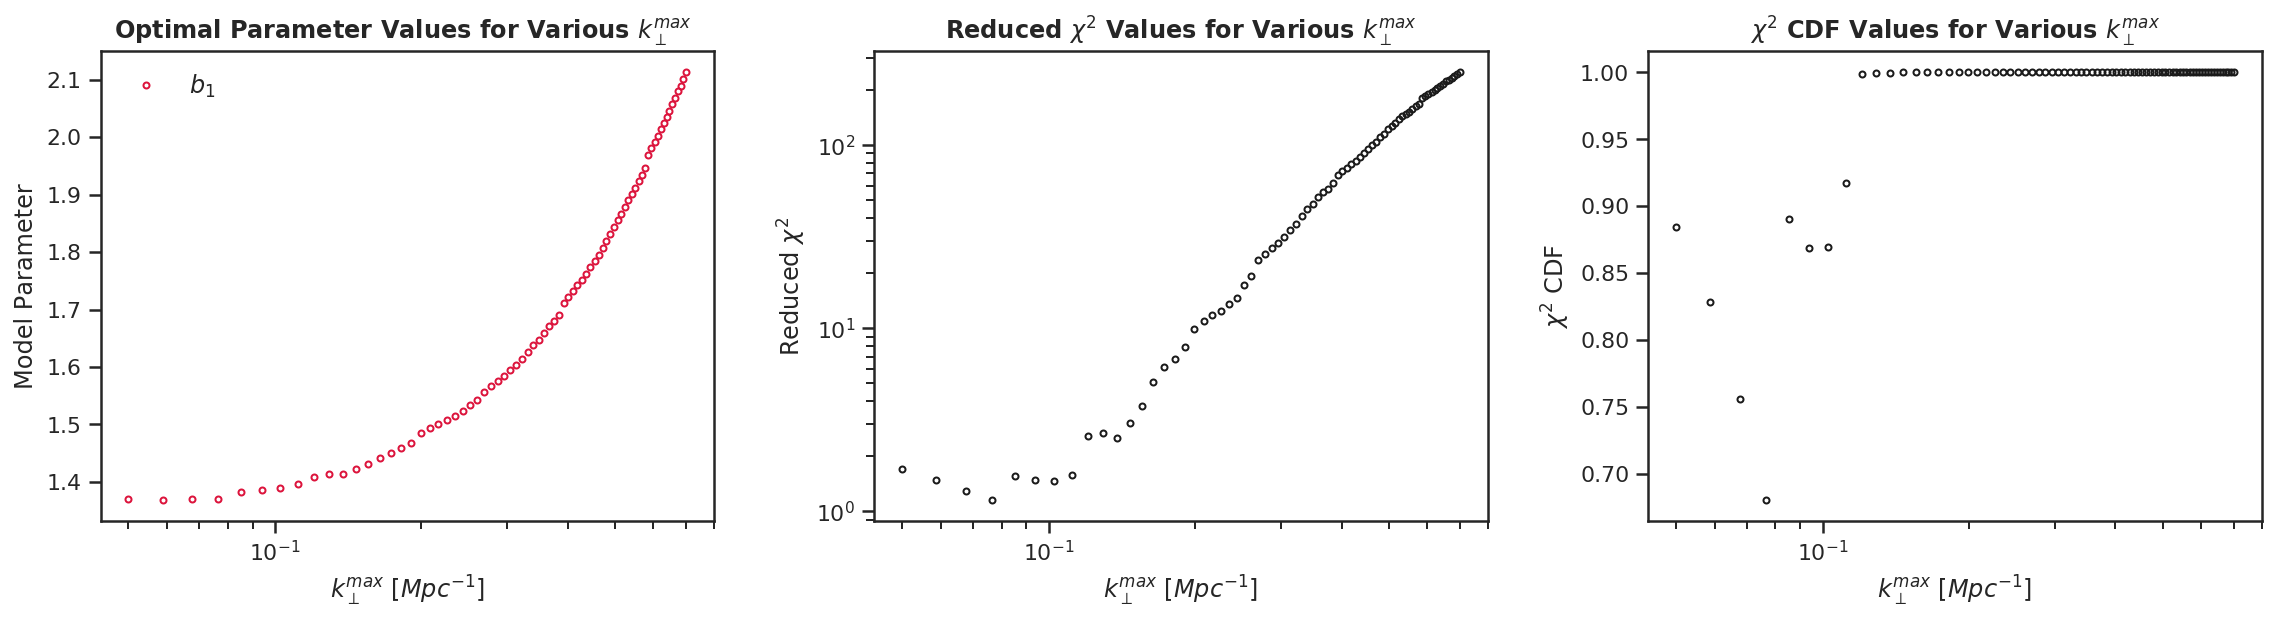

In [9]:
plt.figure(figsize=(16, 4.5))

# Model Parameter Plot
plt.subplot(1, 3, 1)
plt.plot(k_max_arr, b_arr, 'o', markersize=3, markeredgecolor="crimson",
         markerfacecolor="None", label=r"$b_1$", markeredgewidth=1)
plt.title(r"Optimal Parameter Values for Various $k_\perp^{max} $  ", fontweight="bold")
plt.xscale("log")
plt.xlabel("$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel("Model Parameter")
plt.legend(loc="upper left", fontsize=12, frameon=False)

# Reduced Chi_2 Plot
plt.subplot(1, 3, 2)
plt.plot(k_max_arr, reduced_chi_sq, 'o', markersize = 3, markerfacecolor = "None", 
         markeredgecolor = "k", markeredgewidth=1)
plt.title(r"Reduced $\chi^2$ Values for Various $k_\perp^{max}$ ", fontweight = "bold")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel("Reduced $\chi^2$")

# Chi_2 CDF Plot
plt.subplot(1, 3, 3)
plt.plot(k_max_arr, cdf_arr[0:], 'o', markersize = 3,
         markerfacecolor = "None", markeredgecolor = "k", markeredgewidth=1)
plt.title(r"$\chi^2$ CDF Values for Various $k_\perp^{max}$ ", fontweight = "bold")
plt.xscale("log")
plt.xlabel("$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel("$\chi^2$ CDF")

plt.tight_layout()

plt.show()

#### **One Parameter Model Particular Fit:**

Having identified the maximum values at which the fit applies in the above cells, we now analyze a particular fit. The cells below fit the one parameter model over a specified range of k values, for this example we fit:
$$k_\perp \in \ (0.01 \ \textrm{Mpc}^{-1}, 0.1 \ \textrm{Mpc}^{-1}) $$

Plots the resulting fit with the data as well as the associated residuals

In [10]:
# Fit over a specified k interval given by (k_min_fit, k_max_fit)
k_min_fit = 0.01
k_max_fit = 0.1

fit_indices = np.where((k_avg < k_max_fit) & (k_avg > k_min_fit))
k_fit = k_avg[fit_indices]
p_k_fit = p_k_avg[fit_indices]
n_modes_fit = n_modes_avg[fit_indices]

b_guess = [1.7] #  This tells the fit to use a one parameter model
is_linear = True #  Use the linear matter power spectrum

res = scipy.optimize.minimize(neg_log_like, b_guess, method='Nelder-Mead',
                              args=(k_fit, p_k_fit, n_modes_fit, is_linear))

# Compute variances
p_theory = get_pow_2d(k_avg, res.x, is_linear)
var_p_k_avg = 2*p_theory**2/n_modes_avg

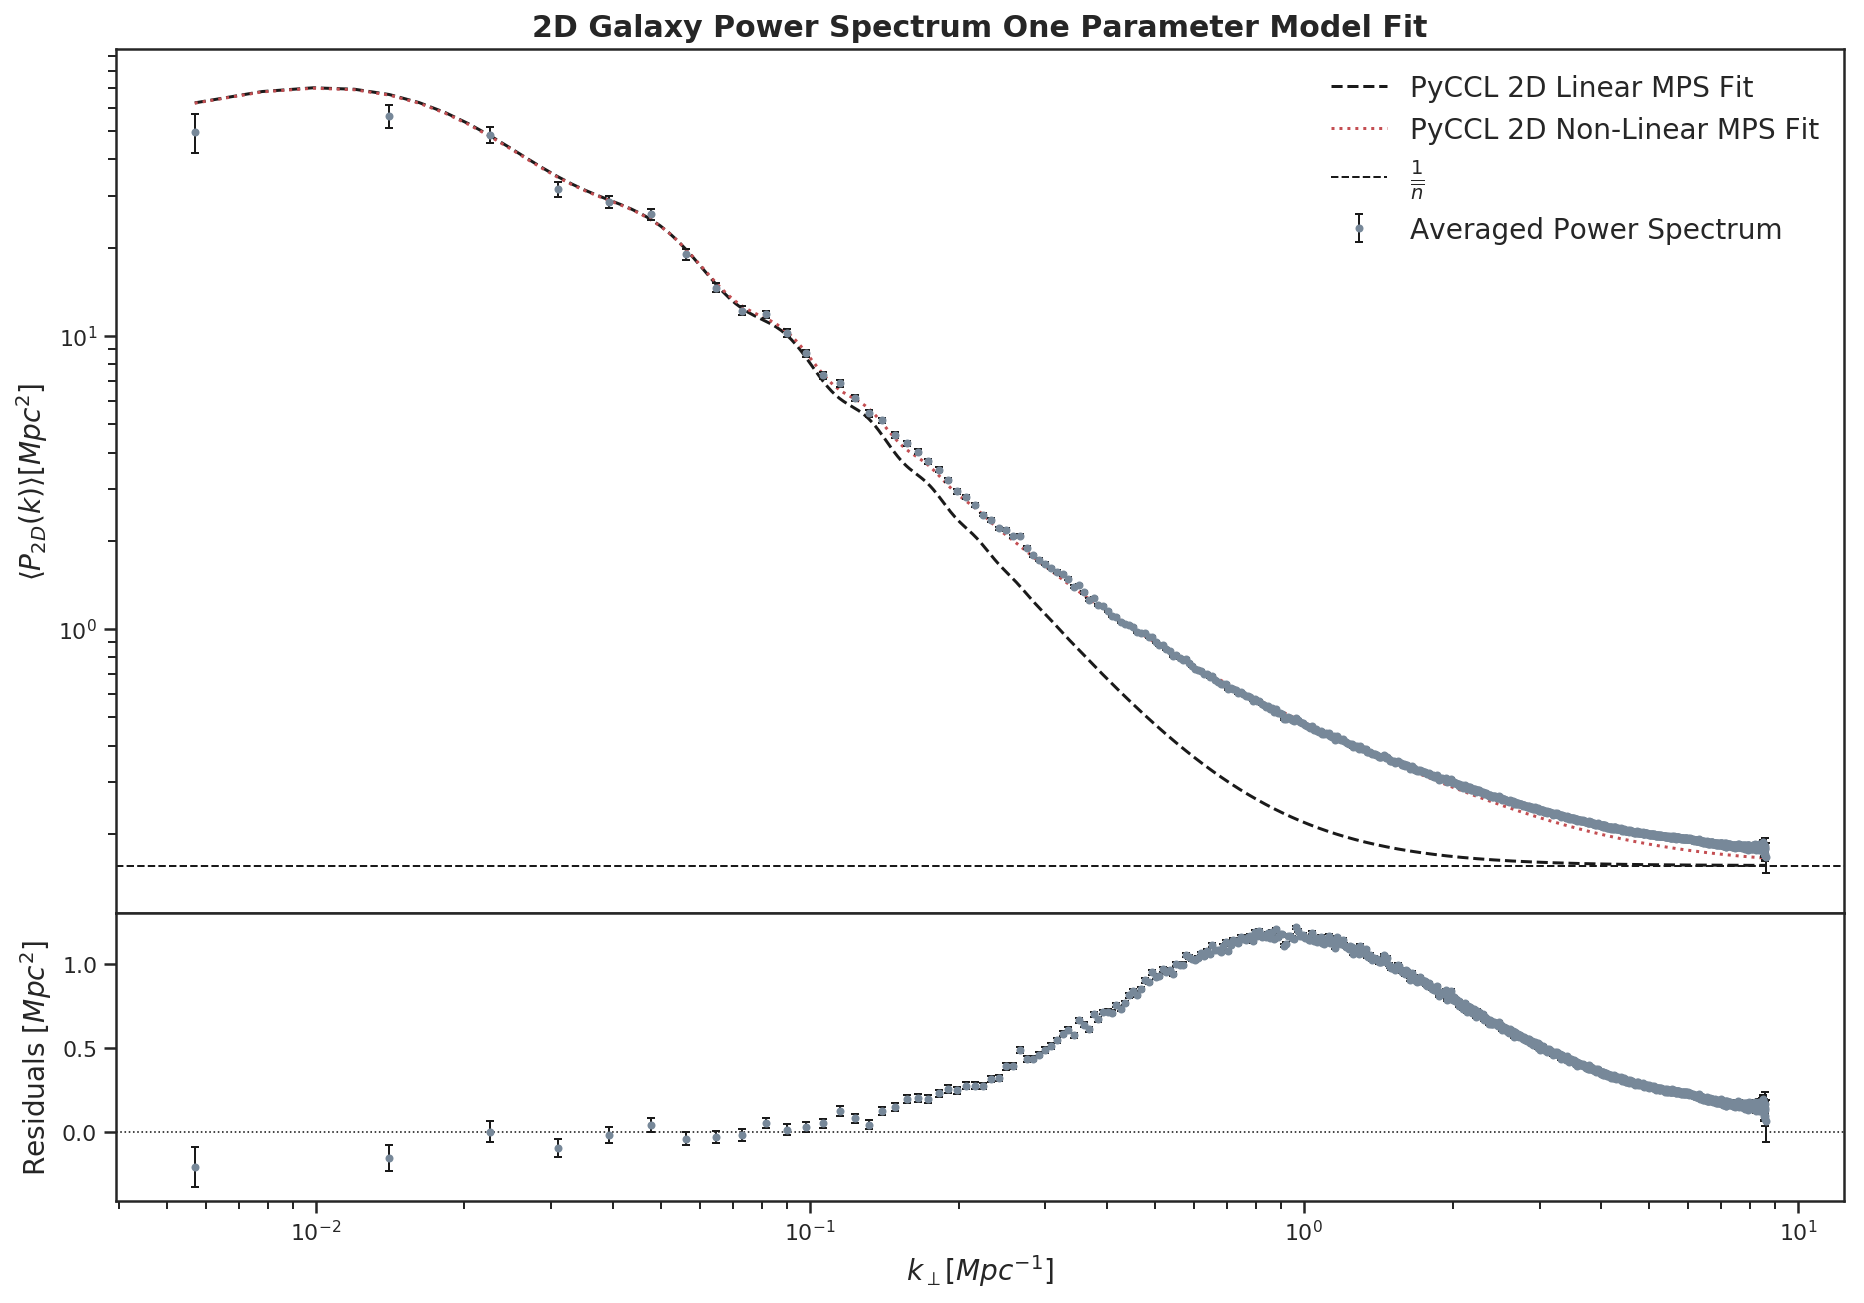

In [11]:
# Plot over a specified k interval
k_min_plot = 0.0
k_max_plot = 10.0

subset_indices = np.where((k_avg < k_max_plot) & (k_avg > k_min_plot))
k_subset = k_avg[subset_indices]
p_k_subset  = p_k_avg[subset_indices]
n_modes_subset = n_modes_avg[subset_indices]
p_theory_subset = p_theory[subset_indices]
var_subset = var_p_k_avg[subset_indices]

# Plot data with residuals
plt.figure(figsize = (12,10))
fig_1 = plt.figure(1)
frame_1 = fig_1.add_axes((0.0, 0.3, 1.0, 0.6))

ax = plt.gca()

k_theoretical = np.linspace(np.min(k_subset), np.max(k_subset), 4096)
plt.plot(k_theoretical, get_pow_2d(k_theoretical, res.x, is_linear=True), 
         color = "k",  linestyle  = "dashed",label = "PyCCL 2D Linear MPS Fit")

plt.plot(k_theoretical, get_pow_2d(k_theoretical, res.x, is_linear=False), 
         color = "r" , linestyle = ":",label = "PyCCL 2D Non-Linear MPS Fit")

plt.errorbar(k_subset, p_k_subset, yerr=np.sqrt(var_subset), marker = '.', 
             color = "lightslategrey", linestyle = "none", markersize = 6, 
             ecolor = 'k', elinewidth = 1, capsize=2, markeredgewidth=1,
             label = "Averaged Power Spectrum")
ax.axhline(1/N_BAR, label = r"$\frac{1}{\overline{n}}$", linewidth = 1, color = "k",
           linestyle = "dashed")

plt.title("2D Galaxy Power Spectrum One Parameter Model Fit", fontweight = "bold", fontsize=15)
plt.xlabel(r"$k_\perp [Mpc^{-1}]$")
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle [Mpc^{2}]$", fontsize=14)

leg = plt.legend(loc = "upper right", fontsize=14, frameon=False) 
plt.xscale("log")
plt.yscale("log")
limits = ax.get_xlim()

# Add residual plot
frame_2 = fig_1.add_axes((0.0, 0.1, 1.0, 0.2))

ax = plt.gca()

p_measure = p_k_subset
residual  = (p_measure-p_theory_subset)/p_theory_subset

# Compute error associated with residual
sigma_t = np.sqrt(2/n_modes_subset)*p_theory_subset

plt.errorbar(k_subset, residual, yerr=sigma_t/p_theory_subset, marker = '.', 
             color = "lightslategrey", linestyle = "none", markersize = 6, 
             ecolor = 'k', elinewidth = 1, capsize=2, markeredgewidth=1)

ax.axhline(0, linestyle = ":", color = "k", linewidth = 0.8)
ax.set_xlim(limits)

plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize=14)
plt.ylabel(r"Residuals $[Mpc^{2}]$", fontsize=14)
plt.xscale("log")

#### **Fit Power Spectrum with Two Parameters:**

Fits power spectrum data to previously defined two parameter model over a range of $k_{max}$ values.

In [12]:
# Define lowest and highest k_max value to fit up to
k_max_low = 0.05
k_max_high = 0.7

k_max_arr = np.linspace(k_max_low, k_max_high, 75)
    
b_guess = [1.7, 1.0]
is_linear = True

b_arr, cdf_arr, reduced_chi_sq = fit_to_kmax(k_max_arr, k_avg, p_k_avg,
                                             n_modes_avg, b_guess, is_linear)

Progress: [------------------->] 100%

#### **Plot Two Parameter Model Fit Data:**

Make various plots about the best fit data. First set of plots shows the results of fits up to various values of $k_\perp^{max}$ by plotting the model parameters, reduced $\chi^2$, and $\chi^2$ cdf values, as a function of $k_\perp^{max}$. 

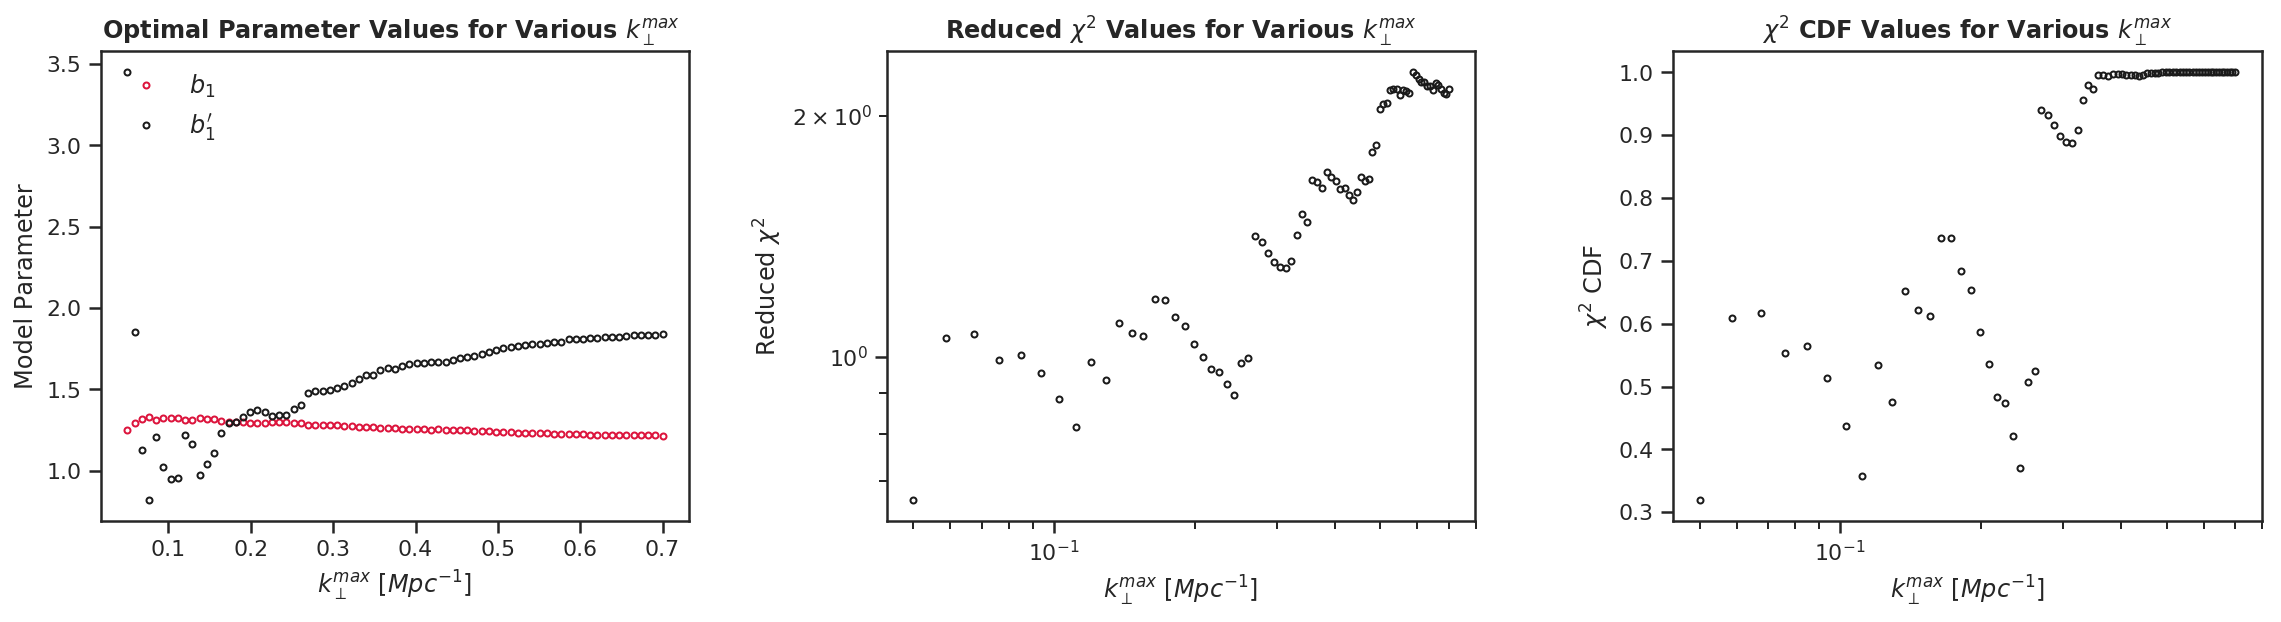

In [13]:
plt.figure(figsize=(16, 4.5))

# Separate bias parameters to construct array of b_1 and array of b_1' values for plotting
b_1_arr = [b[0] for b in b_arr]
b_1_p_arr = [b[1] for b in b_arr]

# Model Parameter Plot
plt.subplot(1, 3, 1)
plt.plot(k_max_arr, b_1_arr, 'o', markersize=3, markeredgecolor="crimson",
         markerfacecolor="None", label=r"$b_1$", markeredgewidth=1)
plt.plot(k_max_arr, b_1_p_arr, 'o', markersize=3, markeredgecolor="k",
         markerfacecolor="None", label=r"$b_1'$", markeredgewidth=1)
plt.title(r"Optimal Parameter Values for Various $k_\perp^{max} $  ", fontweight="bold")
plt.xlabel("$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel("Model Parameter")
plt.legend(loc="upper left", fontsize=12,  frameon=False)

# Reduced Chi_2 Plot
plt.subplot(1, 3, 2)
plt.plot(k_max_arr, reduced_chi_sq, 'o', markersize = 3, markerfacecolor = "None", 
         markeredgecolor = "k", markeredgewidth=1)
plt.title(r"Reduced $\chi^2$ Values for Various $k_\perp^{max}$ ", fontweight = "bold")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel("Reduced $\chi^2$")

# Chi_2 CDF Plot
plt.subplot(1, 3, 3)
plt.plot(k_max_arr, cdf_arr[0:], 'o', markersize = 3,
         markerfacecolor = "None", markeredgecolor = "k", markeredgewidth=1)
plt.title(r"$\chi^2$ CDF Values for Various $k_\perp^{max}$ ", fontweight = "bold")
plt.xscale("log")
plt.xlabel("$k_\perp^{max} \ [Mpc^{-1}]$")
plt.ylabel("$\chi^2$ CDF")

plt.tight_layout()

#### **Two Parameter Model Particular Fit:**

Having identified the maximum values at which the fit applies in the above cells, we now analyze a particular fit. The cells below fit the two parameter model over a specified range of k values, for this example we fit:
$$k_\perp \in \ (0.0 \ \textrm{Mpc}^{-1}, 0.3 \ \textrm{Mpc}^{-1}) $$

Plots the resulting fit with the data as well as the associated residuals

In [14]:
# Fit over a srogressecified k interval
k_min_fit = 0.0
k_max_fit = 0.3

fit_indices = np.where((k_avg < k_max_fit) & (k_avg > k_min_fit))
k_fit = k_avg[fit_indices]
p_k_fit = p_k_avg[fit_indices]
n_modes_fit = n_modes_avg[fit_indices]

b_guess = [1.7, 1.0]
res = scipy.optimize.minimize(neg_log_like, b_guess, method='Nelder-Mead',
                              args=(k_fit, p_k_fit, n_modes_fit, 
                                    is_linear))

# Compute variances
p_theory = get_pow_2d(k_avg, res.x, is_linear)
var_p_k_avg = 2*p_theory**2/n_modes_avg

# Define interval to plot fit over
k_min_plot = 0.0
k_max_plot = 10.0

subset_indices = np.where((k_avg < k_max_plot) & (k_avg > k_min_plot))
k_subset = k_avg[subset_indices]
p_k_subset  = p_k_avg[subset_indices]
n_modes_subset = n_modes_avg[subset_indices]
p_theory_subset = p_theory[subset_indices]
var_subset = var_p_k_avg[subset_indices]

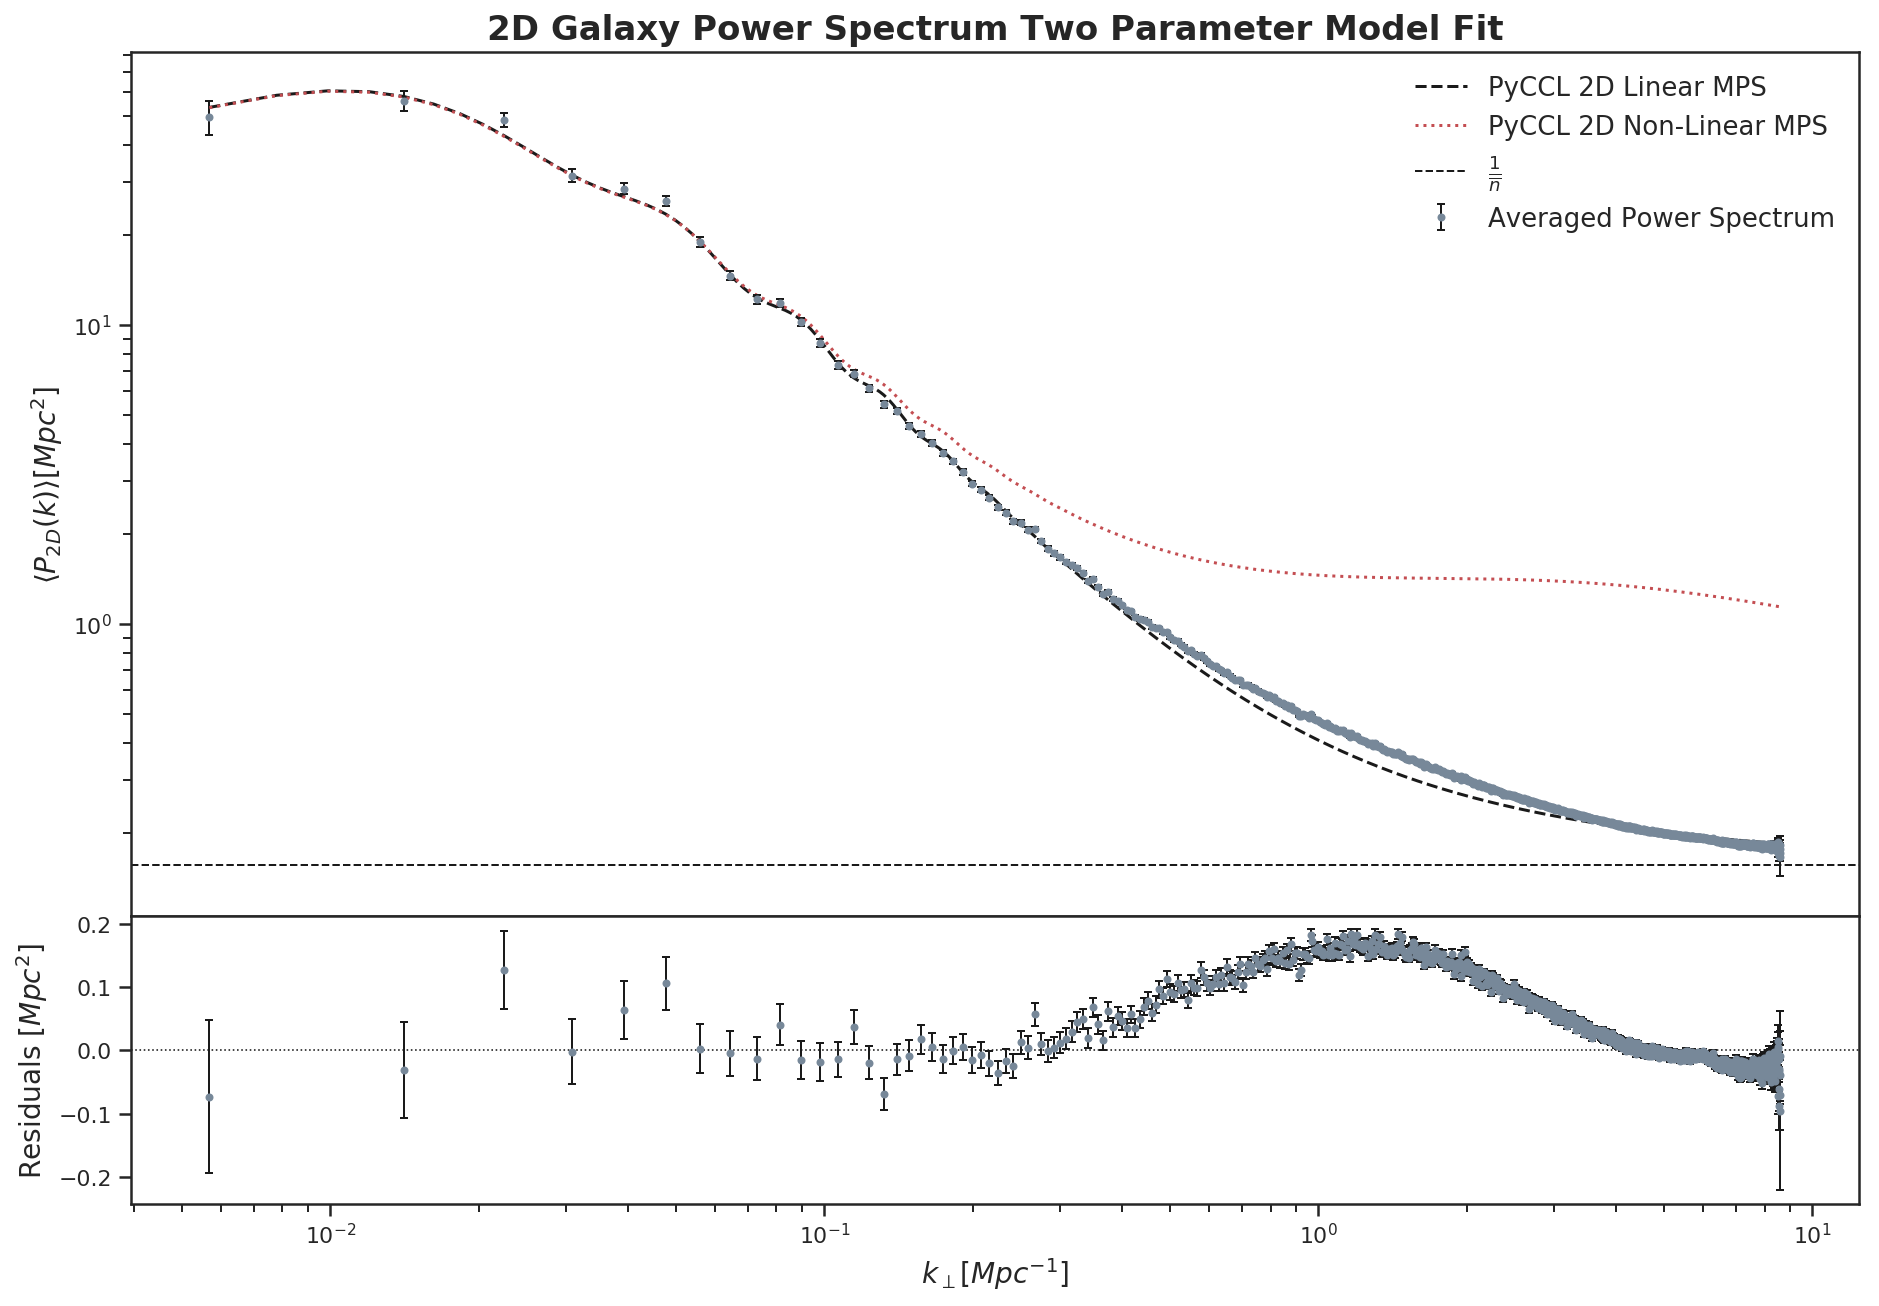

In [15]:
# Plot data with model fit
plt.figure(figsize = (12,10))
fig_1 = plt.figure(1)
frame_1 = fig_1.add_axes((0.0, 0.3, 1.0, 0.6))

ax = plt.gca()

k_theoretical = np.linspace(np.min(k_subset), np.max(k_subset), 4096)
plt.plot(k_theoretical, get_pow_2d(k_theoretical, res.x, is_linear=True), 
         color = "k",  linestyle  = "dashed",label = "PyCCL 2D Linear MPS")

plt.plot(k_theoretical, get_pow_2d(k_theoretical, res.x, is_linear=False), 
         color = "r" , linestyle = ":",label = "PyCCL 2D Non-Linear MPS")

plt.errorbar(k_subset, p_k_subset, yerr=np.sqrt(var_subset), marker = '.', 
             color = "lightslategrey", linestyle = "none", markersize = 6, 
             ecolor = 'k', elinewidth = 1, capsize=2, markeredgewidth=1,
             label = "Averaged Power Spectrum")
ax.axhline(1/N_BAR, label = r"$\frac{1}{\overline{n}}$", linewidth = 1, color = "k",
           linestyle = "dashed")

plt.title("2D Galaxy Power Spectrum Two Parameter Model Fit", fontweight = "bold", fontsize=17)
plt.xlabel(r"$k_\perp [Mpc^{-1}]$")
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle [Mpc^{2}]$", fontsize=14)

leg = plt.legend(loc = "upper right", fontsize = 13,  frameon=False) 
plt.xscale("log")
plt.yscale("log")

limits = ax.get_xlim()

# Compute/plot residuals
frame_2 = fig_1.add_axes((0.0, 0.1, 1.0, 0.2))

ax = plt.gca()

p_measure = p_k_subset
residual  = (p_measure-p_theory_subset)/p_theory_subset

# Compute error associated with residual
sigma_t = np.sqrt(2/n_modes_subset)*p_theory_subset

plt.errorbar(k_subset, residual, yerr=sigma_t/p_theory_subset, marker = '.', 
             color = "lightslategrey", linestyle = "none", markersize = 6, 
             ecolor = 'k', elinewidth = 1, capsize=2, markeredgewidth=1)

ax.axhline(0, linestyle = ":", color = "k", linewidth = 0.8)
ax.set_xlim(limits)

plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"Residuals $[Mpc^{2}]$", fontsize=14)
plt.xscale("log")